# Supplementary Figure 6

In [1]:
import os.path as op
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import plotutils

In [2]:
df_dir = op.join('..', 'data', 'dataframes')

In [3]:
subjects, rois, tasks = plotutils.default_data()

In [4]:
plotutils.set_plot_style()

### Load dataframes

In [5]:
ang_data = pd.read_csv(op.join(df_dir, 'group_ang_data.csv'))
ang_boots = pd.read_csv(op.join(df_dir, 'group_ang_data_boots.csv'))

pred_data = pd.read_csv(op.join(df_dir, 'pRFpred_group_ang_data.csv'))
pred_boots = pd.read_csv(op.join(df_dir, 'pRFpred_group_ang_data_boots.csv'))

### Calculate prf prediction goodness-of-fit metrics

In [6]:
def fit_scale(data, prediction):
    
    # find best fitting scale factor
    data_mean = data.groupby(['ang_dist_bin']).mean()['beta_adj'].values
    pred_mean = prediction.groupby(['ang_dist_bin']).mean()['beta_adj'].values
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(pred_mean.reshape(-1, 1), data_mean.reshape(-1, 1))   
    scale = regr.coef_.flatten()
    
    return scale

In [7]:
def pred_r2(data, prediction, scale):
    
    # calculate r2 for prediction and scaled prediction
    r2 = r2_score(data, prediction)
    r2_scale = r2_score(data, scale*prediction) 
    
    return r2, r2_scale

In [8]:
def goodness_of_fit(pred, data, boots=False):
    
    r2_df = []
    
    # Group data and predictions 
    dg = data.groupby('task')
    pg = pred.groupby('prf_model')
    
    # Calculate goodness of fit for each grouping 
    # of data and predictions
    for (task, d), (pm, p) in itertools.product(dg, pg):
        
        # fit a scale factor across all rois
        s = fit_scale(d, p)
        
        # group data and predictions by rois (and optionally boots)
        if boots:
            cols = ['roi', 'n_boot']
        else:
            cols = ['roi']
        droi = d.groupby(cols)['beta_adj']
        proi = p.groupby(cols)['beta_adj']
        
        # calculate r2 and r2 with scale factor 
        # separately for each roi
        for ((dv, dr), (rv, pr)) in zip(droi, proi):
                        
            # get r2 metrics
            r2, r2_scale = pred_r2(dr, pr, s)
            
            # save dataframe
            d1 = dict(task=task, prf_model=pm,
                      r2=r2, r2_scale=r2_scale, 
                      scale=s)
            d2 = dict(zip(cols, np.atleast_1d(dv)))
            r2_df.append(pd.DataFrame({**d1, **d2}))
            
    r2_df = pd.concat(r2_df).reset_index(drop=True)
    r2_df = r2_df.melt(id_vars=['task', 'prf_model', 'scale']+cols, 
                       value_vars=['r2', 'r2_scale'], var_name=['acc_measure'])
    
    return r2_df

In [9]:
pred_dog = pred_data.query("prf_model=='pred_dog'").reset_index()
r2_df = goodness_of_fit(pred_dog, ang_data)

In [10]:
pred_dog_boots = pred_boots.query("prf_model=='pred_dog'").reset_index()
r2_boots_df = goodness_of_fit(pred_dog_boots, ang_boots, boots=True)

In [11]:
prf_conf = (r2_boots_df.groupby(['roi', 'task', 'prf_model', 'acc_measure'])['value']
                               .apply(np.percentile, [16, 84])
                               .reset_index())

### Supplementary Figure 6

In [12]:
pal = ['#1b9e77', '#82c8b3']
pal_dict = dict(zip(tasks, pal))
z_dict = dict(zip(tasks, [-10, 10]))

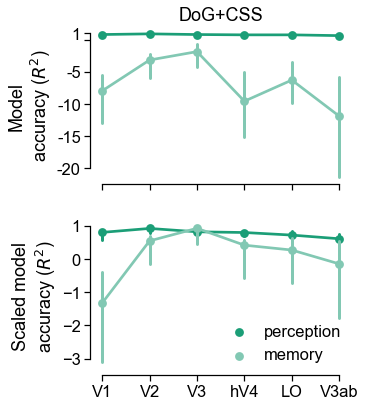

In [13]:
# Plot r2 and scaled r2 for perception and memory data for each roi
g = sns.catplot(x='roi', y='value', order=rois, row='acc_measure', 
                hue='task', palette=pal, hue_order=tasks, kind='point', 
                dodge=False, join=True, height=3, aspect=1.8, sharey=False, 
                legend=False, data=r2_df)

# Plot error bars
for i, measure in enumerate(g.row_names):
    ax = g.axes.flatten()[i]
    facet_df = prf_conf.query("acc_measure==@measure")
    for (task, roi), df in facet_df.groupby(["task", "roi"]):
        x_i = rois.index(roi)
        ax.plot([x_i, x_i], df['value'].iloc[0], linewidth=3, c=pal_dict[task],
                alpha=1, zorder=z_dict[task], solid_capstyle='round')
    
g.set(xlabel='')
g.axes[0][0].set()
g.axes[0][0].set(yticks=[-20, -15, -10, -5, 0, 1], yticklabels=[-20, -15, -10, -5, "", 1])
g.axes[0][0].set(ylabel='Model\naccuracy ($R^2$)')
g.axes[0][0].set_title('DoG+CSS')
g.axes[1][0].set(ylim=[-3.5, 1.25], yticks=[-3, -2, -1, 0, 1])
g.axes[1][0].set(ylabel='Scaled model\naccuracy ($R^2$)')
g.axes[1][0].set_title('')

handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(loc='center left', frameon=False, handletextpad=.5, 
                 bbox_to_anchor=(.45, 0.2))

sns.despine(trim=True)
plt.gcf().tight_layout(h_pad=1.5)

In [14]:
r2_df.groupby(['task', 'acc_measure']).agg([np.max, np.min])['value']

amax       amin
task       acc_measure                     
memory     r2          -1.841189 -11.889746
           r2_scale     0.924674  -1.326407
perception r2           0.928083   0.652075
           r2_scale     0.920566   0.610133